## Simple Vowel Synth

This script is a simple vowel synth using audiopy and audiolazy to create vowel
sounds using simple gaussian noice as input. The input is objected to spectrum 
analysis and frequencies are used as a seed. It then generates a sound in the form
pyaudio stream form using the formant frequencies of vowels. It was developped as 
part of the "Projet Realisation Technique" for the Master 1 in Signal and Image Processing 
at Aix-Marseille University 2019-2020. 

The main purpose of this document is to create a baseline for vowel synthesis using
basic signal processing, exploiting the formant frequencies of each vowel. A vowel is
formed by three formant frequencies as well as multiple harmonic frequencies.

#### Signal analysis

Before creating our synth it was vital to analyse signals of vowels and determine their characteristics. To achieve that we manipulated each signal's spectrum. We used Discrete Fourier Transform to study the signals as well as well as Linear Prediction Coefficients to verify the formants of each vowel.Our baseline for each vowels formant frequencies can be found [here](https://www.researchgate.net/publication/8155079_Phonetic_and_phonological_analysis_of_progressive_speech_degeneration_A_case_study). Our data was sourced from this [repository](https://linguistics.ucla.edu/people/hayes/103/).

The following script for example plots the module of the spectrum of /i/ and performs LPC to determine the formant frequency.


22050


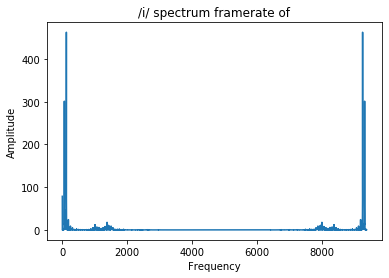

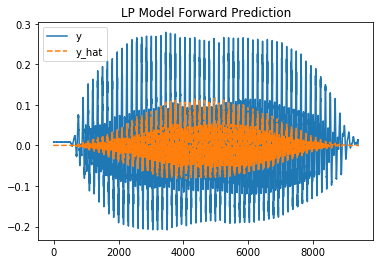

Formant frequency list  [442.4432497935913]


In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import librosa
import numpy
import math

# Import vowel file
y, sr = librosa.load("./VChart/i.wav")
print(sr)
i_spectrum = numpy.abs(scipy.fft(y))
# Plot FFT module
plt.figure()
plt.plot(i_spectrum)
plt.ylabel('Amplitude')
plt.xlabel('Frequency')
plt.title('/i/ spectrum framerate of')
plt.show()

# Get Hamming window.
N = len(y)
w = numpy.hamming(N)

# Apply window and high pass filter.
y1 = y * w
y1 = scipy.signal.lfilter([1., -0.63], 1, y1)

# Get LPC
a = librosa.lpc(y1, 2)
y_hat = scipy.signal.lfilter([0] + -1*a[1:], [1], y1)

# Plot
plt.figure()
plt.plot(y)
plt.plot(y_hat, linestyle='--')
plt.legend(['y', 'y_hat'])
plt.title('LP Model Forward Prediction')
plt.show()

env,_,_ = compute_envelope(y_hat, win_len_sec=1, Fs=sr)

# Find roots of function
rts = numpy.roots(a)
rts = [r for r in rts if numpy.imag(r) >= 0]

# Get angles.
angz = numpy.arctan2(numpy.imag(rts), numpy.real(rts))

# Get frequencies.

frqs = sorted(angz * (sr / (2 * math.pi)))
print("Formant frequency list ", frqs)

#### Signal Synthesis

We then start creating a baseline. We are trying to use sinusoid signals with frequencys based on  the formant we determined previously for each vowel. At first we use simple scipy functions to synthesize the vowels' sound and experimented with the contents of the signal. We added the formant frequencies, harmonics to simulate timbre, as well as filters that ameliorate our sounds. 

We then proceeded to create a audiolazy model that inputs a gaussian noise and returns a pyaudio stream of the same duration.

##### Simple Synthesis using scipy

In [2]:
# Imports
from scipy import signal
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

In [3]:
def smooth(x,window_len=100):

    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y

The most basic way to synthesize a vowel is by producing a periodical signal of the formant frequency of said vowel. As a first attempt we use the signal module of scipy to synthesize a sinusoidal wave with a frequency of 437Hz. It is also common practice to use saw-tooth waves.

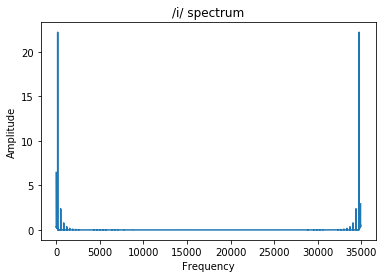

In [14]:
# Create a linear space. Our goal is to create a signal that lasts
# for 1 second and has a samplerate of 44100Hz which is the 
# samplerate of a CD recording
t = np.linspace(0, 1, 44100)

#sig =  signal.chirp(t, f0=459, f1=459, t1=44100, method='linear')
#sig = smooth(np.sin(437 * np.pi * t))

sig =  smooth(signal.square(437 * np.pi * t))

# Plot signal spectrum
plt.figure()
plt.plot(numpy.abs(scipy.fft(sig)))
plt.ylabel('Amplitude')
plt.xlabel('Frequency')
plt.title('/i/ spectrum')
plt.show()

# Normalize signal to 0db
sig =librosa.util.normalize(sig)

# Save wave file
wavfile.write("sawtooth.wav",44100,sig)

We can ameliorate our results using various techniques. Our main is goal is to form the vowel's tibre. This is mainly done by adding harmonic frequencies and processing the signal using filters and envelopes. In our next approach we will create a signal using the first 3 formants and some harmonics and the mix our audio using two simple functions that we sourced from this [tutorial](https://www.audiolabs-erlangen.de/resources/MIR/FMP/C1/C1S3_Timbre.html).

When using the scipy.signal.sawtooth there is no need to add harmonics since it generates an infinite amount of harmonics as opposed to numpy.sin.

In [5]:
def compute_ADSR(len_A=.10, len_D=10, len_S=60, len_R=10, height_A=1.0, height_S=0.5):
    """Computation of idealized ADSR model
    
    Notebook: C1/C1S3_Timbre.ipynb
    
    Args: 
        len_A, len_D, len_S, len_R: Length (samples) of A, D, S, R phases
        height_A, height_S: height in A and S phases.
    
    Returns: 
        curve_ADSR: ADSR model
    """     
    curve_A = np.arange(len_A) * height_A / len_A
    curve_D = height_A - np.arange(len_D) * (height_A - height_S) / len_D
    curve_S = np.ones(len_S) * height_S
    curve_R = height_S * (1 - np.arange(1, len_R + 1) / len_R)
    curve_ADSR = np.concatenate((curve_A, curve_D, curve_S, curve_R))
    return curve_ADSR


def generate_vibrato(sig,dur=1, Fs=44100, amp=0.5, freq=440, vib_amp=1, vib_rate=30):
    """Generation of a sinusoid signal with vibrato
    
    Notebook: C1/C1S3_Timbre.ipynb
    
    Args: 
        dur: Duration (in seconds)
        Fs: Sampling rate
        amp: Amplitude of sinusoid
        vib_amp: Amplitude (Hz) of the frequency oscillation
        vib_rate: Rate (Hz) of the frequency oscillation
    
    Returns: 
        x: Generated signal
        t: Time axis (in seconds)
    """     
    num_samples = int(Fs * dur)
    t = np.arange(num_samples) / Fs    
    freq_vib = freq + vib_amp * sig
    phase_vib = np.zeros(num_samples)
    for i in range(1, num_samples):
        phase_vib[i] = phase_vib[i-1] + 2 * np.pi * freq_vib[i-1] / Fs
    x = amp * np.sin(phase_vib)
    return x

In [16]:
def compute_envelope(x, win_len_sec=0.01, Fs=4000):
    """Computation of a signal's envelopes
    
    Notebook: C1/C1S3_Timbre.ipynb
    
    Args: 
        x: Signal (waveform) to be analyzed
        win_len_sec: Length (seconds) of the window
        Fs: Sampling rate
    
    Returns: 
        env: Magnitude envelope
        env_upper: Upper envelope
        env_lower: Lower envelope
    """         
    win_len = round(win_len_sec * Fs)
    win_len_half = round(win_len_sec * Fs * 0.5)
    N = x.shape[0]
    env = np.zeros(N)
    env_upper = np.zeros(N)
    env_lower = np.zeros(N)
    for i in range(N):
        i_start = max(0, i - win_len_half)
        i_end = min(N, i + win_len_half)
        env[i] = np.amax(np.abs(x)[i_start:i_end])
        env_upper[i] = np.amax(x[i_start:i_end])
        env_lower[i] = np.amin(x[i_start:i_end])    
    return env, env_upper, env_lower



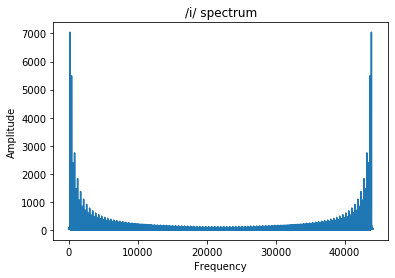

In [43]:
# Allocating linear space
t = np.linspace(0, 1, 44100)

# Formant frequencies
sig = 3*signal.sawtooth(437 * np.pi * t)
sig = 3*sig + signal.sawtooth(2761 * np.pi  * t)
sig = 3*sig + signal.sawtooth(3372 * np.pi  * t)
    

#envelope = librosa.core.resample(compute_ADSR(len_A=20, len_D=2, len_S=60, len_R=1, height_A=2.0, height_S=1.2), 83, 44100)
envelope = librosa.core.resample(env, 9390, 44100)

sig = envelope*sig
sig = sig+generate_vibrato(sig)

sig = librosa.util.normalize(sig, axis=0)
wavfile.write("sawtooth.wav",44100,np.real(sig))

plt.figure()
plt.plot(numpy.abs(scipy.fft(sig)))
plt.ylabel('Amplitude')
plt.xlabel('Frequency')
plt.title('/i/ spectrum')
plt.show()



The sound now resembles a heavily "computerized"since we used sawtoooth waves but also becomes more recognisable. We will now to try to use sinusoidal waves and add the harmonic content ourselves.

We will also create a  suite of vowel sounds. Each vowel sound has a duration of 1 s with a framerate of 44100Hz which is the standard samplerate of a CD.

Our goal for the next example will be to recreate a deep choral voice and this is why we will be using mostly 
low frequency harmonics


In [7]:
def add_harmonics(sig,freq,n, step=1,weight=1):
    output = sig
    np.arange
    for i in np.arange(0,n,step):
         output = output + (1-i/n)*weight* np.sin(i*freq * np.pi * t)
    return output

In [46]:
# Formant information for each vowel in dictionary form
formant = {
    "i": [437,2761,3372],
    "u": [459, 1105,2735],
    "o": [555,1035,2654],
    "a": [936, 1551,2489],
    "e": [536,1975,2530],
}

# List of vowels to produce
vowels = ["i", "u", "o", "a", "e", "i"]


def play_vowels(vowel_list):
    output = np.asarray([0])
    for vowel in vowel_list:
        t = np.linspace(0, 1, 44100)
        # Formant frequencies
        sig = 3*np.sin(formant[vowel][0] * np.pi * t)
        sig = 2*sig + np.sin(formant[vowel][1] * np.pi  * t)
        sig = 1*sig + np.sin(formant[vowel][2] * np.pi  * t)
        
        # Add harmonics
        sig  =  add_harmonics(sig,formant[vowel][0],2,0.1,3)
        sig  =  add_harmonics(sig,formant[vowel][0],10,2,3)
        sig  =  add_harmonics(sig,formant[vowel][1],1,0.1,2)
        sig  =  add_harmonics(sig,formant[vowel][2],1,0.1,1)
        
        # Add ADSR envelope for each vowel
        #envelope = librosa.core.resample(compute_ADSR(len_A=20, len_D=2, len_S=60, len_R=10, height_A=2.0, height_S=1.2), 92, 44100)
        sig = envelope*sig
        
        # Concatenate signal
        output = np.concatenate((output,sig),axis=None)
        
    # Mix Audio 
    output_harmonic = librosa.effects.harmonic(output)
    output_harmonic = librosa.effects.pitch_shift(output_harmonic, 44100, -10, bins_per_octave=12, res_type='kaiser_best')
    
    # Normalize to 0db 
    output_harmonic = librosa.util.normalize(output_harmonic, axis=0)
    
    # Filter
    b, a = signal.butter(3, 0.6)
    output_harmonic = signal.filtfilt(b, a, output_harmonic)
    
    # Save to file
    wavfile.write("sawtooth.wav",44100,output_harmonic)
    
play_vowels(vowels)

### Audiolazy synthesizer approach

In this approach we will be using the audiolazy library for python coupled with pyaudio to create a stream based on a gaussian noise input. This small synthesizer emulates a robotic voice.

In [47]:
# Import lbraries
from __future__ import unicode_literals, print_function
from audiolazy import (sHz, maverage, rint, AudioIO, ControlStream,thub,Streamix,tostream,
                        ParallelFilter, CascadeFilter, resonator,sin_table, saw_table,attack, chunks)# for DSP
from time import sleep
import sys
import wave
from scipy import fft
import numpy as np

#### Generate input from noise

In [58]:
# Generate input using numpy
formants = {
    "i": 437,
    "u": 459,
    "o": 555,
    "a": 936,
    "e": 536,
}
fundamentals = [437,459,555,936,536]
def get_key(val): 
    for key, value in formants.items(): 
         if val == value: 
            return key 
  
    return "key doesn't exist"

def create_vowel_list(formants_dict,data):
    values = np.asarray([i for i in formants.values()]).flatten()
    vowels = []
    for i in data:
        if i in values :
            vowels.append(get_key(i))
        else:
            vowels.append(" ")
    return(vowels)

def generate_input():
    noise = np.random.randn(100)
    spectrum = fft(noise)
    data_list = []
    for i in range(0,100,10):
        data_list.append(437*np.abs(np.mean(spectrum[i:i+9])))
    data = np.asarray([data_list])


    new_data = []
    for i in data.flatten():
        if i >1000:
            new_data.append(936)
        else:
            new_data.append(min(fundamentals, key=lambda x:abs(x-i)))
    
    return new_data

input_list = generate_input()
vowel_list = create_vowel_list(formants,input_list)
print(vowel_list)

['a', 'o', 'a', 'a', 'a', 'a', 'a', 'a', 'o', 'a']


In [73]:

# Initialization
rate = 44100
s, Hz = sHz(rate)
inertia_dur = .5 * s
inertia_filter = maverage(rint(inertia_dur))

# Initialize api options
api = None
chunks.size = 16

### Filters

This is a set of basic filters written in audiolazy

In [74]:
from audiolazy import lazy_filters

def echo (sig, echo_time):
    sig = thub(sig/2, 2)
    smixer = Streamix()
    smixer.add(0,sig)
    smixer.add(echo_time*s,sig)
    return smixer


@tostream
def the_flang(sig, freq, lag):
    posicao = lambda senoide: int((lag*s/2000.0)*(senoide+1))
    senoide = sinusoid(freq*Hz,phase=-pi/2)  
    ms = 1e-3*s
    lista = zeros().take(lag * ms + 1) 
    tam = len(lista)-1
    for el,v in izip(sig,senoide):
        lista.append(el)
        lista.pop(0)
        yield (el + lista[tam-posicao(v)])/2

def o_flanger(freq=0.3,lag=2):
    """
    Flanger effect.
    Its like the echo, but the delay time varies sinusoidally.
    """
    dic = {u"Frequency (mHz)":(.3,float,(.01,5))
        , u"Lag (ms)":(2,float,(1,50))}
    inst = Filtro(the_flang, dic, u"Flanger")
    inst.vparams[0] = freq
    inst.vparams[1] = lag
    return inst

def high_pass (signal,cutoff):
        filt = lazy_filters.highpass(cutoff*Hz)
        return filt(signal)

In [79]:
vowels = ["i", "u", "o", "a", "e", "i"]

formants = {
    "i": [437,2761,3372],
    "u": [459, 1105,2735],
    "o": [555,1035,2654],
    "a": [936, 1551,2489],
    "e": [536,1975,2530],
    " ": [0,0,0]
}
# Create function to synthesize interpolated vowels in loop
def play_vowels_2formants_interp(formants, vowels):
    # Use the with statement to close the player when complete and prevent degredation of audio sythesis
    with AudioIO(api=api) as player:
        # Initialize formant streams for sythesis using first vowel
        first_coeffs = formants[vowels[0]]
        f1 = ControlStream(first_coeffs[0] * Hz)
        f2 = ControlStream(first_coeffs[1] * Hz)
        f3 = ControlStream(first_coeffs[2] * Hz)
        gain = ControlStream(0) # Apply gain to fade in smoothly
        

        # Generate signal using cascade filter
        filt = CascadeFilter([
          resonator.z_exp(inertia_filter(f1).skip(inertia_dur), 400 * Hz),
          resonator.z_exp(inertia_filter(f2).skip(inertia_dur), 2000 * Hz),
          resonator.z_exp(inertia_filter(f3).skip(inertia_dur), 3000 * Hz),
        ])
        #sig = attack(1,5,7)
        sig = filt((saw_table)(500 * Hz)) * inertia_filter(gain)
        the_flang(sig,300*Hz,2.)

        # Begin player in the background
        th = player.play(sig)
        prev_vowel = None
        # Loop through vowels and play
        for vowel in vowels:
            if prev_vowel is not None: # If not the first vowel interpolate between current and previous vowels
                coeffs = [0]*len(formants[vowel])
                for i in range(len(formants[vowel])):
                    coeffs[i] = (formants[vowel][i] + formants[prev_vowel][i])/2
                print("Now changing between: {} and {}".format(prev_vowel, vowel))
                f1.value = coeffs[0] * Hz
                f2.value = coeffs[1] * Hz
                f3.value = coeffs[2] * Hz

                sleep(1)
            # Play current vowel
            coeffs = formants[vowel]
            print("Now playing: ", vowel)
            f1.value = coeffs[0] * Hz
            f2.value = coeffs[1] * Hz
            f3.value = coeffs[2] * Hz
            gain.value = 0.5 # Apply gain to fade in smoothly
            sleep(1) # Sleep to allow vowel to be synthesized by player
            prev_vowel = vowel

        # Fade out sound smoothly
        gain.value = 0
        sleep(inertia_dur / s + .2) # Divide by s because here it's already expecting a value in seconds, and we don't want ot give a value in a time-squaed unit like s ** 2
# Play interpolated vowel quadrilateral
play_vowels_2formants_interp(formants, vowel_list)

Now playing:  a
Now changing between: a and o
Now playing:  o
Now changing between: o and a
Now playing:  a
Now changing between: a and a
Now playing:  a
Now changing between: a and a
Now playing:  a
Now changing between: a and a
Now playing:  a
Now changing between: a and a
Now playing:  a
Now changing between: a and a
Now playing:  a
Now changing between: a and o
Now playing:  o
Now changing between: o and a
Now playing:  a
